In [275]:
import pandas as pd
import numpy as np
from datetime import date, timedelta
from pathlib import Path
from tratamento import trata_acomph, a0_a1

In [276]:
def get_prod():
    loc = Path('../ex_csv/produtibilidades/prod.csv')
    prod = pd.read_csv(loc, index_col=0)
    for i,row in prod.head(154).iterrows():
        row['prod'] = row['prod'].replace(",",".")
        row['prod'] = float(row['prod'])
    return prod

In [277]:
def importa_arquivos():
    acomph = trata_acomph.get_csv()
    produtibilidade = get_prod()
    a0, a1 = a0_a1.get_csv()
    local = Path('../ex_csv')
    local_post = local / 'postos.csv'
    postos = pd.read_csv(local_post, index_col=0)
    return acomph, a0, a1, postos, produtibilidade

In [278]:
def get_datas():
    meses = []
    for i in range(1,31):
        meses = [((date.today()-timedelta(days=i)).month)] + meses
    return meses

In [279]:
def trata_vazoes_base(acomph, a1):
    vazoes_base = acomph.loc[a1.iloc[:,0], :]
    vazoes_base.reset_index(inplace=True)
    base = a1.reset_index()
    indice = base.loc[:,'posto']
    vazoes_base.insert(0, "ind", indice, allow_duplicates=True)
    vazoes_base.drop('posto', axis=1, inplace=True)
    vazoes_base.rename(columns={'ind':'posto'}, inplace=True)
    vazoes_base.set_index('posto', inplace=True)
    vazoes_base.dropna(inplace=True)
    return vazoes_base

In [280]:
def cria_ena():
    acomph, a0, a1, postos, produtibilidades = importa_arquivos()
    ind = acomph.head(155).index
    col = (acomph.T).head(30).index
    ena = pd.DataFrame(0,index = ind, columns = col)
    ena = ena.add(ena_tipo_0(ena,acomph,produtibilidades,postos), fill_value = 0)
    ena = ena.add(ena_tipo_1(ena,acomph,produtibilidades,postos,a0,a1), fill_value = 0)
    return ena

In [281]:
def ena_tipo_0(ena, acomph, produtibilidades, postos):
    vazoes_tipo0 = acomph.join(postos.query('tipo==0'),
                               on = 'posto', how = 'inner')
    vazoes_tipo0.drop(['nome','bacia','ree','sub_mer','tipo'],
                      axis=1, inplace=True)
    produtibilidade_tipo0 = produtibilidades.join(postos.query('tipo==0'),
                                                  on = 'posto', how = 'inner')
    produtibilidade_tipo0.drop(['nome','bacia','ree','sub_mer','tipo'], axis=1, inplace=True)
    for i in range(30):
        ena_dia = vazoes_tipo0.iloc[:,i].multiply(produtibilidade_tipo0['prod'], fill_value=0)
        ena.iloc[:,i] = ena.iloc[:,i].add(ena_dia, fill_value = 0)
    return ena

In [282]:
def ena_tipo_1(ena, acomph, produtibilidades, postos, a0, a1):
    meses = get_datas()
    vazoes_tipo1 = acomph.join(postos.query('tipo==1'),
                               on = 'posto', how = 'inner')
    vazoes_tipo1.drop(['nome','bacia','ree','sub_mer','tipo'],
                      axis=1, inplace=True)
    produtibilidade_tipo1 = produtibilidades.join(postos.query('tipo==1'),
                                                 on='posto', how='inner')
    produtibilidade_tipo1.drop(['nome','bacia','ree','sub_mer','tipo'],
                              axis=1, inplace=True)
    vazoes_base = trata_vazoes_base(acomph, a1)
    for i in range(30):
        A0 = a0.iloc[:,meses[i]]
        A1 = a1.iloc[:,meses[i]]
        X = vazoes_base.iloc[:,i]
        Y = A0 + (A1*X)
        ena_dia = Y.multiply(produtibilidade_tipo1['prod'], fill_value=0)
        ena.iloc[:,i] = ena.iloc[:,i].add(ena_dia, fill_value = 0)
    return ena

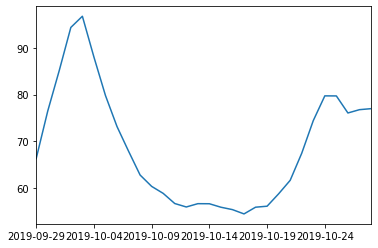

In [287]:
e = cria_ena()
e.loc[134,:].plot()